# Imports and Setup

In [1]:
# Importing necessary libraries
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from tensorflow.keras.applications import InceptionV3, MobileNetV2, DenseNet121, Xception
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from tensorflow.keras.preprocessing import image


# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the dataset_path
dataset_dir = 'cell_images'

# List all subdirectories (each representing a class)
classes = os.listdir(dataset_dir)

# Initialize a dictionary to store the count of images in each class
class_count = {class_name: len(os.listdir(os.path.join(dataset_dir, class_name))) for class_name in classes}

# Print the results
for class_name, num_images in class_count.items():
    print(f"Number of {class_name} Images: {num_images}")

# Print the total number of classes and images
total_classes = len(classes)
total_images = sum(class_count.values())
print(f"\nTotal Classes: {total_classes}, Total Images: {total_images}")

Number of Parasitized Images: 13779
Number of Uninfected Images: 13779

Total Classes: 2, Total Images: 27558


# Data Loading and Exploration

In [3]:
# Define the paths to the folders containing the images
uninfected_dir = os.path.join(dataset_dir, 'Uninfected')
parasitized_dir = os.path.join(dataset_dir, 'Parasitized')

# Function to load images and labels
def load_images(folder, label):
    return [(os.path.join(folder, filename), label) for filename in os.listdir(folder) if filename.endswith(".png")]

# Load images and labels from both folders
file_paths_labels = load_images(uninfected_dir, "Uninfected") + load_images(parasitized_dir, "Parasitized")

# Create a DataFrame from the collected data
data = pd.DataFrame(file_paths_labels, columns=["file_path", "label"])

# Display the first few rows of the DataFrame
print(data.head())

# Save the DataFrame to a CSV file
data.to_csv("image_data.csv", index=False)

                                           file_path       label
0  cell_images\Uninfected\C100P61ThinF_IMG_201509...  Uninfected
1  cell_images\Uninfected\C100P61ThinF_IMG_201509...  Uninfected
2  cell_images\Uninfected\C100P61ThinF_IMG_201509...  Uninfected
3  cell_images\Uninfected\C100P61ThinF_IMG_201509...  Uninfected
4  cell_images\Uninfected\C100P61ThinF_IMG_201509...  Uninfected


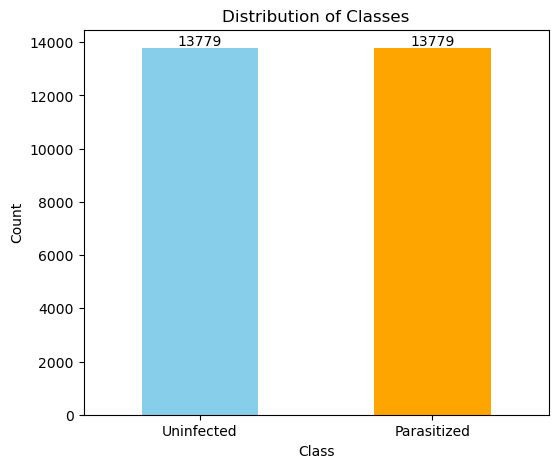

In [4]:
# Load the CSV file
data = pd.read_csv("image_data.csv")

# Plotting
plt.figure(figsize=(6, 5))
ax = data['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add labels on top of each bar
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.05,
            str(round(i.get_height(), 2)), ha='center', va='bottom')

plt.show()

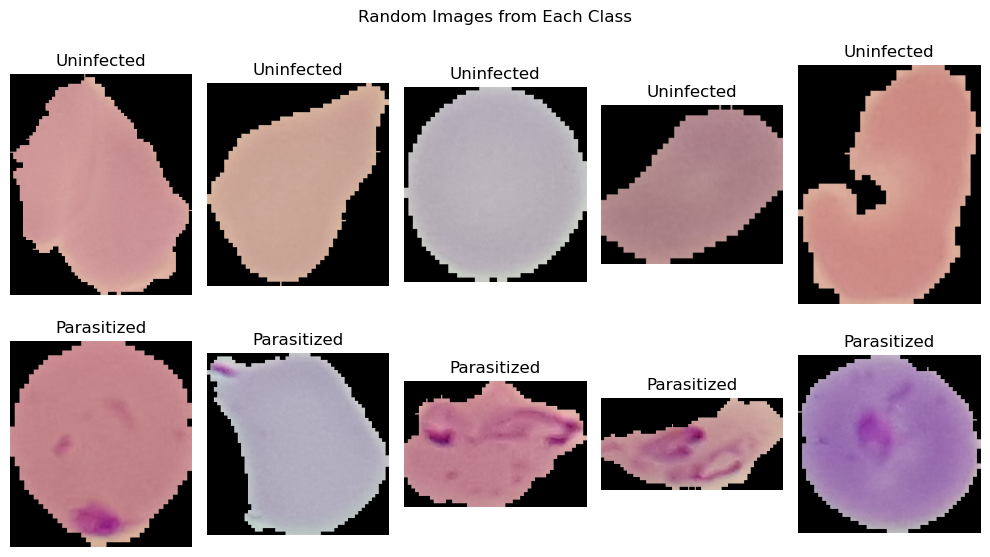

In [5]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the paths to the folders containing the images
folders = {'Uninfected': os.path.join(dataset_dir, 'Uninfected'),
           'Parasitized': os.path.join(dataset_dir, 'Parasitized')}

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))
fig.suptitle('Random Images from Each Class')

# Plot random images from each class
for i, (class_name, folder) in enumerate(folders.items()):
    image_files = os.listdir(folder)

    # Shuffle the list of image files
    np.random.shuffle(image_files)

    # Take the first 5 images after shuffling
    random_images = image_files[:5]

    for j, image_name in enumerate(random_images):
        img_path = os.path.join(folder, image_name)
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name)

plt.tight_layout()
plt.show()

In [6]:
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Further splitting the training data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['label'])

In [7]:
import shutil

# Define function to copy/move images
def copy_images(data, destination_dir):
    for index, row in data.iterrows():
        file_path = row['file_path']
        label = row['label']
        # Create directory if not exists
        label_dir = os.path.join(destination_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        # Check if file already exists in destination directory
        destination_file = os.path.join(label_dir, os.path.basename(file_path))
        if not os.path.exists(destination_file):
            # Copy/move image to destination directory
            shutil.copy(file_path, label_dir)  # Use shutil.move if you want to move instead of copying

# Define destination directories for train, test, and validation sets
train_dir = 'train_images'
test_dir = 'test_images'
val_dir = 'val_images'

# Copy images to destination directories
copy_images(train_data, train_dir)
copy_images(test_data, test_dir)
copy_images(val_data, val_dir)

In [8]:
# Count the number of images in each class for training, validation, and test sets
train_counter = Counter(train_data['label'])
val_counter = Counter(val_data['label'])
test_counter = Counter(test_data['label'])

# Print the results
print("Training Set:")
print(train_counter)
print(f"Total: {len(train_data)} images\n")

print("Validation Set:")
print(val_counter)
print(f"Total: {len(val_data)} images\n")

print("Test Set:")
print(test_counter)
print(f"Total: {len(test_data)} images")

Training Set:
Counter({'Uninfected': 9921, 'Parasitized': 9920})
Total: 19841 images

Validation Set:
Counter({'Parasitized': 1103, 'Uninfected': 1102})
Total: 2205 images

Test Set:
Counter({'Uninfected': 2756, 'Parasitized': 2756})
Total: 5512 images


# Data Augmentation and Generators

In [9]:
# Define augmentation parameters
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Generate batches of augmented data
input_shape = (128, 128, 3)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data,
                                                    x_col='file_path',
                                                    y_col='label',
                                                    target_size=(input_shape[0], input_shape[1]),
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    seed=2)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_data,
                                                x_col='file_path',
                                                y_col='label',
                                                target_size=(input_shape[0], input_shape[1]),
                                                batch_size=64,
                                                class_mode='binary',
                                                shuffle=False,
                                                seed=2)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                  x_col='file_path',
                                                  y_col='label',
                                                  target_size=(input_shape[0], input_shape[1]),
                                                  batch_size=64,
                                                  class_mode='binary',
                                                  shuffle=False)

Found 19841 validated image filenames belonging to 2 classes.
Found 2205 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.


In [11]:
train_shape = (len(train_data),) + (train_generator.image_shape)
val_shape = (len(val_data),) + (val_generator.image_shape)
test_shape = (len(test_data),) + (test_generator.image_shape)

print("Training set shape:", train_shape)
print("Validation set shape:", val_shape)
print("Test set shape:", test_shape)

Training set shape: (19841, 128, 128, 3)
Validation set shape: (2205, 128, 128, 3)
Test set shape: (5512, 128, 128, 3)


In [12]:
print(len(train_generator))
print(len(val_generator))
print(len(test_generator))

311
35
87


In [13]:
def plot_training_history(history, figsize=(16, 6)):
    plt.figure(figsize=figsize)
    plt.style.use('seaborn-v0_8-darkgrid')

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Model Building and Training

## CNN model

In [14]:
# Define the model
cnn_model = Sequential()

# Convolutional layers
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Flatten layer
cnn_model.add(Flatten())

cnn_model.add(Dropout(0.5))
# Fully connected layers
cnn_model.add(Dense(256, activation='relu'))

cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [15]:
callbacks = [
    ModelCheckpoint(filepath='malaria_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    TensorBoard(log_dir='tensorboard_logs', histogram_freq=1, write_graph=True, write_images=True)
]

In [16]:
# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks)

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.7701
Epoch 1: val_accuracy improved from -inf to 0.93333, saving model to malaria_cnn_model.h5
311/311 [==============================] - 520s 2s/step - loss: 0.4863 - accuracy: 0.7701 - val_loss: 0.1923 - val_accuracy: 0.9333
Epoch 2/20
311/311 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9300
Epoch 2: val_accuracy improved from 0.93333 to 0.94966, saving model to malaria_cnn_model.h5
311/311 [==============================] - 311s 998ms/step - loss: 0.2096 - accuracy: 0.9300 - val_loss: 0.1685 - val_accuracy: 0.9497
Epoch 3/20
311/311 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.9393
Epoch 3: val_accuracy improved from 0.94966 to 0.95556, saving model to malaria_cnn_model.h5
311/311 [==============================] - 309s 993ms/step - loss: 0.1861 - accuracy: 0.9393 - val_loss: 0.1433 - val_accuracy: 0.9556
Epoch 4/20
311/311 [==============

In [15]:
# Load the saved model
cnn_model = load_model('malaria_cnn_model.h5')

In [35]:
# Evaluate the model on training data
train_loss, train_accuracy = cnn_model.evaluate(train_generator, steps=len(train_generator))
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on validation data
val_loss, val_accuracy = cnn_model.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

311/311 [==============================] - 287s 922ms/step - loss: 0.1294 - accuracy: 0.9567
Training Loss: 0.1294, Training Accuracy: 95.67%
35/35 [==============================] - 9s 259ms/step - loss: 0.1188 - accuracy: 0.9646
Validation Loss: 0.1188, Validation Accuracy: 96.46%
87/87 [==============================] - 22s 248ms/step - loss: 0.1232 - accuracy: 0.9603
Test Loss: 0.1232, Test Accuracy: 96.03%


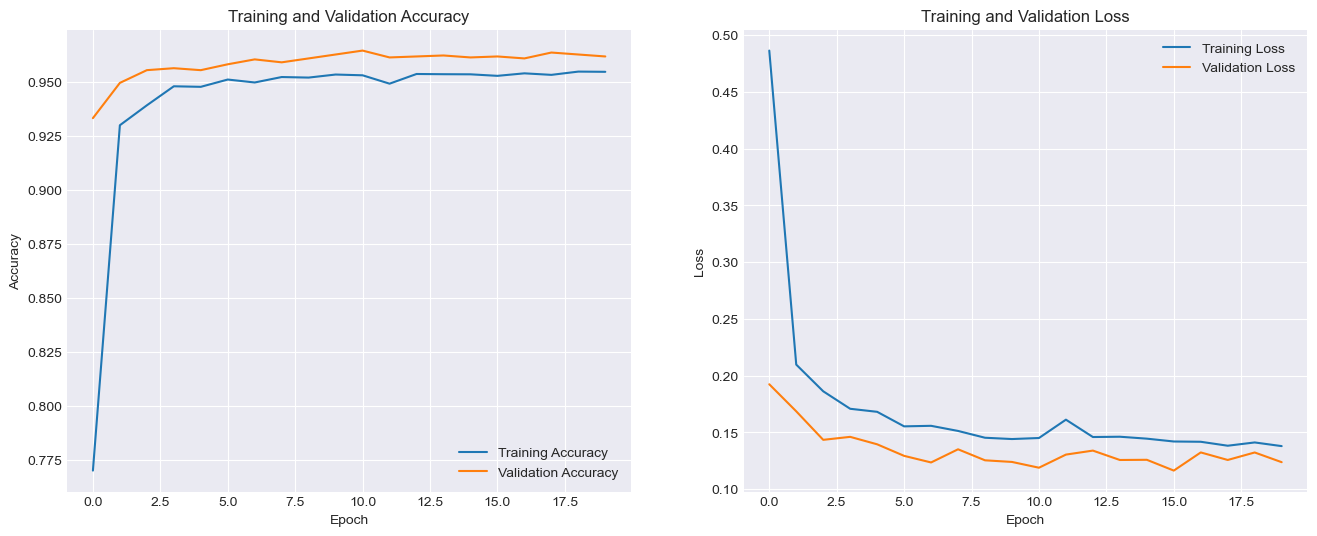

In [19]:
# Plot the training history
plot_training_history(cnn_history)

In [36]:
# Make predictions on the test set
y_pred_prob = cnn_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int) 

# 'test_generator.classes' gives the true labels of test data
true_labels = test_generator.classes

# Print classification report for precision, recall, F1-score
report_cnn = classification_report(true_labels, y_pred)
print(report_cnn)

87/87 [==============================] - 21s 240ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2756
           1       0.95      0.97      0.96      2756

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [22]:
print(test_generator.class_indices)

{'Parasitized': 0, 'Uninfected': 1}


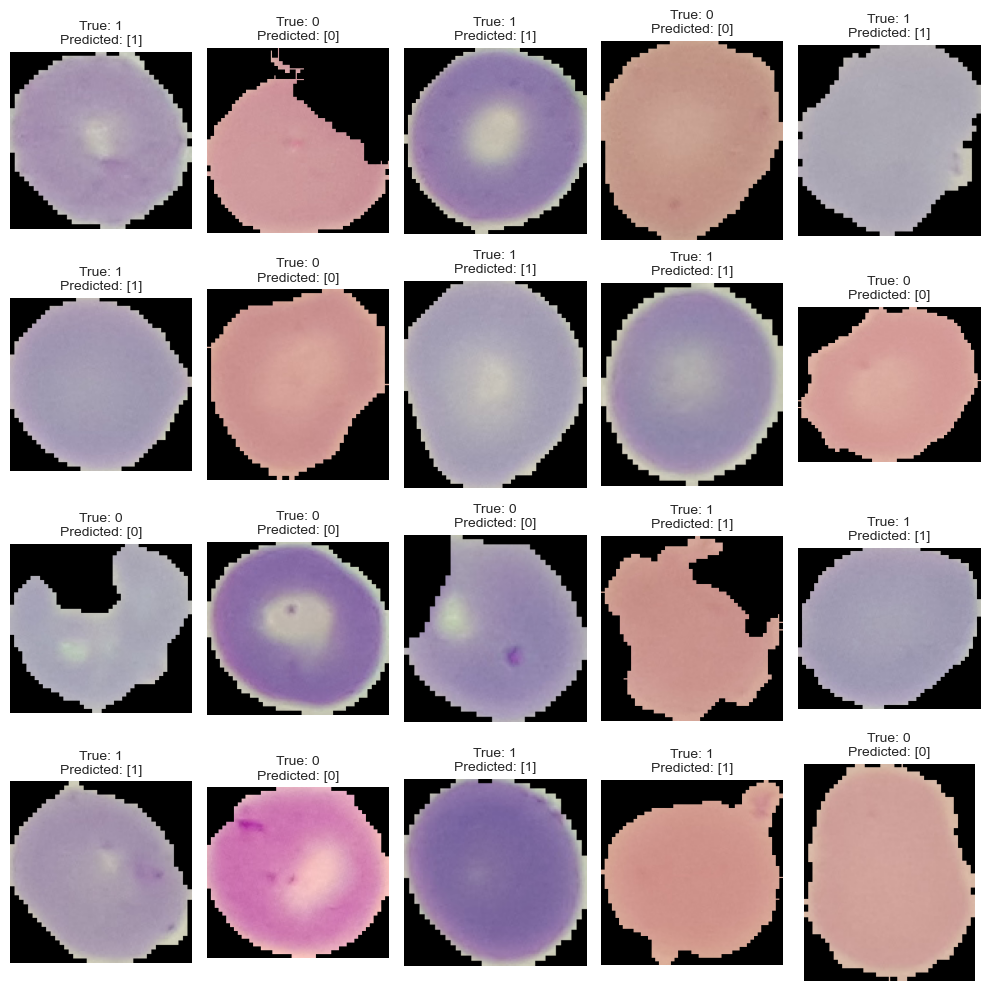

In [23]:
# Plotting predictions for 20 random images
plt.figure(figsize=(10, 10))
num_images = min(20, len(data))
random_indices = np.random.choice(len(test_data), size=num_images, replace=False)  # Generate random indices
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i+1)  
    img = mpimg.imread(data['file_path'].iloc[idx])
    plt.imshow(img)
    plt.title(f"True: {true_labels[idx]}\nPredicted: {y_pred[idx]}", fontsize=10) 
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2627  129]
 [  90 2666]]


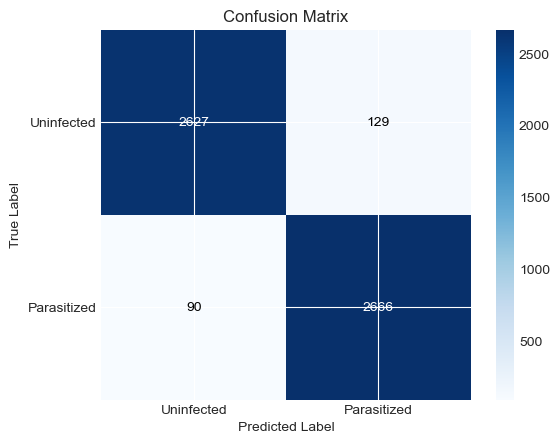

In [25]:
# Plot the confusion matrix with count
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# Annotate each cell with the count
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.yticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.show()

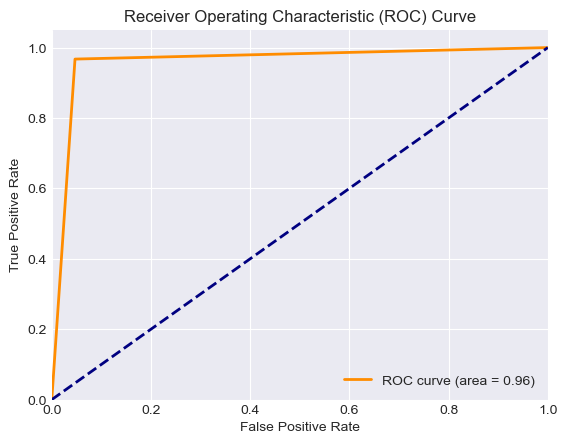

In [26]:
fpr, tpr, thresholds = roc_curve(true_labels, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# InceptionV3

In [27]:
# Load InceptionV3 model with pre-trained weights (exclude top layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a sequential model
inception_model = Sequential()

# Add the InceptionV3 base model to the sequential model
inception_model.add(base_model)

# Add a Flatten layer
inception_model.add(GlobalAveragePooling2D())

# Add a Dense layer with ReLU activation
inception_model.add(Dense(1024, activation='relu'))

# Add a Dropout layer for regularization
inception_model.add(Dropout(0.5))

# Add a Dense layer with sigmoid activation for binary classification
inception_model.add(Dense(1, activation='sigmoid'))

# Compile the model
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
inception_model.summary()

# Specify the filepath with dynamic components
filepath = 'inception_model.h5'

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
__________________________________

In [28]:
callbacks = [
    ModelCheckpoint(filepath='inception_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    TensorBoard(log_dir='tensorboard_logs', histogram_freq=1, write_graph=True, write_images=True)
]

In [29]:
# Train the model
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks)

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.8530
Epoch 1: val_accuracy improved from -inf to 0.91882, saving model to inception_model.h5
311/311 [==============================] - 386s 1s/step - loss: 0.4686 - accuracy: 0.8530 - val_loss: 0.2182 - val_accuracy: 0.9188
Epoch 2/20
311/311 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.8865
Epoch 2: val_accuracy improved from 0.91882 to 0.92472, saving model to inception_model.h5
311/311 [==============================] - 414s 1s/step - loss: 0.2817 - accuracy: 0.8865 - val_loss: 0.2023 - val_accuracy: 0.9247
Epoch 3/20
311/311 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.8887
Epoch 3: val_accuracy improved from 0.92472 to 0.92789, saving model to inception_model.h5
311/311 [==============================] - 386s 1s/step - loss: 0.2740 - accuracy: 0.8887 - val_loss: 0.2007 - val_accuracy: 0.9279
Epoch 4/20
311/311 [==========================

In [16]:
# Load the model
inception_model = load_model('inception_model.h5')

In [38]:
# Evaluate the model on training data
train_loss, train_accuracy = inception_model.evaluate(train_generator, steps=len(train_generator))
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on validation data
val_loss, val_accuracy = inception_model.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on test data
test_loss, test_accuracy = inception_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

311/311 [==============================] - 379s 1s/step - loss: 0.2261 - accuracy: 0.9087
Training Loss: 0.2261, Training Accuracy: 90.87%
35/35 [==============================] - 35s 986ms/step - loss: 0.1878 - accuracy: 0.9338
Validation Loss: 0.1878, Validation Accuracy: 93.38%
87/87 [==============================] - 89s 1s/step - loss: 0.2035 - accuracy: 0.9222
Test Loss: 0.2035, Test Accuracy: 92.22%


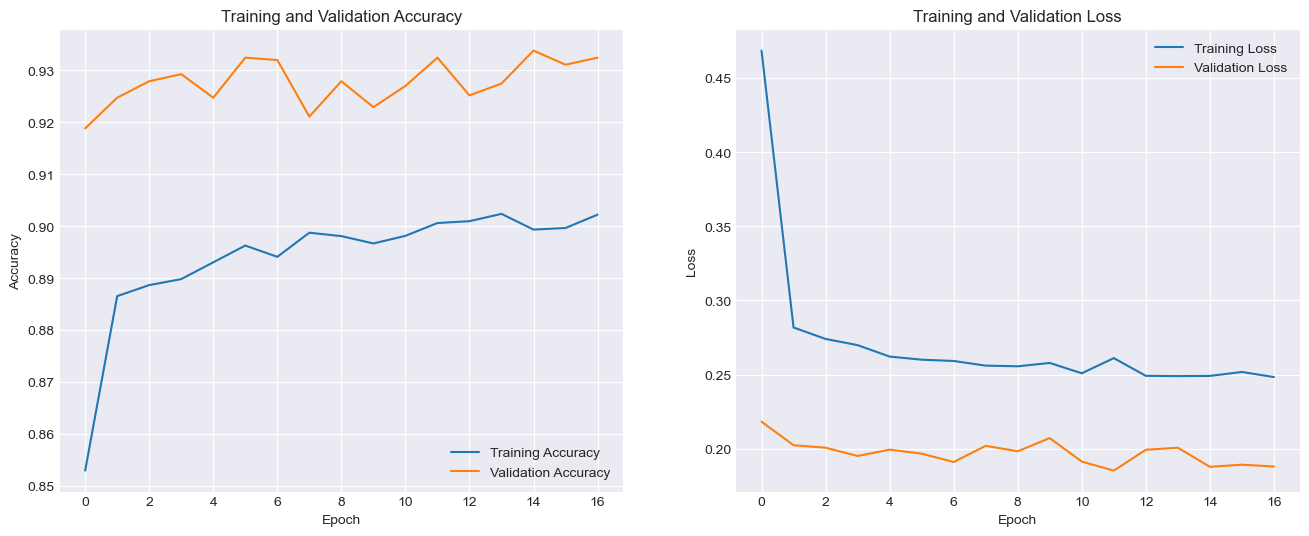

In [32]:
# Plot the training history
plot_training_history(inception_history)

In [39]:
# Make predictions on the test set
y_pred_prob = inception_model.predict(test_generator)
inception_pred = (y_pred_prob > 0.5).astype(int)

# 'test_generator.classes' gives the true labels of test data
inception_true_labels = test_generator.classes

# Print classification report for precision, recall, F1-score
inception_report = classification_report(inception_true_labels, inception_pred)
print(inception_report)

87/87 [==============================] - 87s 984ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2756
           1       0.90      0.95      0.92      2756

    accuracy                           0.92      5512
   macro avg       0.92      0.92      0.92      5512
weighted avg       0.92      0.92      0.92      5512



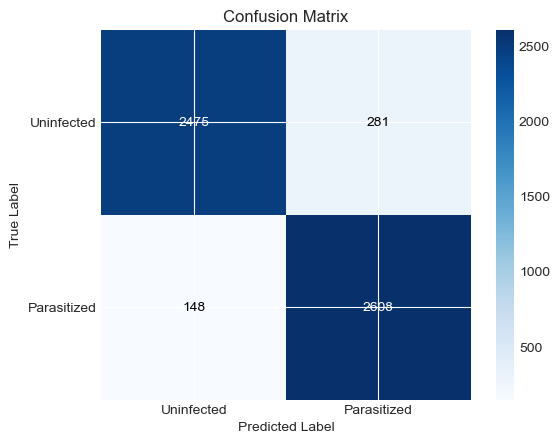

In [34]:
# Generate confusion matrix
conf_matrix = confusion_matrix(inception_true_labels, inception_pred)

# Plot the confusion matrix with count
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# Annotate each cell with the count
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.yticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.show()

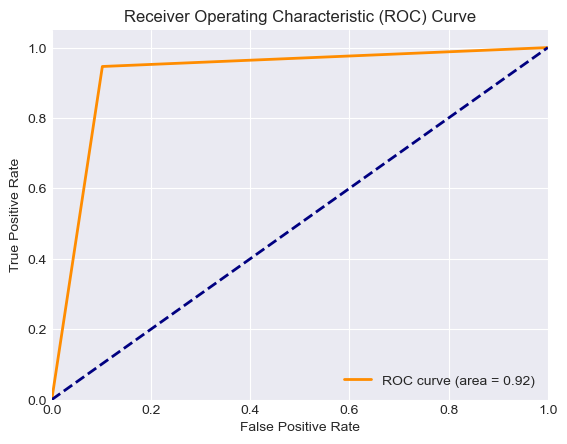

In [35]:
fpr, tpr, thresholds = roc_curve(inception_true_labels, inception_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# MobileNet V2

In [36]:
# Define the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
mobilenet_model = Sequential()

# Add the MobileNetV2 base model to the new Sequential model
mobilenet_model.add(base_model)

# Add a Flatten layer
mobilenet_model.add(GlobalAveragePooling2D())

# Add a Dense layer with ReLU activation
mobilenet_model.add(Dense(1024, activation='relu'))

# Add a Dropout layer for regularization
mobilenet_model.add(Dropout(0.5))

# Add a Dense layer with sigmoid activation for binary classification
mobilenet_model.add(Dense(1, activation='sigmoid'))

# Compile the model
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
No

In [37]:
callbacks = [
    ModelCheckpoint(filepath='mobilenet_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    TensorBoard(log_dir='tensorboard_logs', histogram_freq=1, write_graph=True, write_images=True)
]

In [38]:
# Train the model
mobilenet_history = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks)

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.9094
Epoch 1: val_accuracy improved from -inf to 0.93787, saving model to mobilenet_model.h5
311/311 [==============================] - 226s 709ms/step - loss: 0.2460 - accuracy: 0.9094 - val_loss: 0.1740 - val_accuracy: 0.9379
Epoch 2/20
311/311 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9234
Epoch 2: val_accuracy did not improve from 0.93787
311/311 [==============================] - 409s 1s/step - loss: 0.2047 - accuracy: 0.9234 - val_loss: 0.1748 - val_accuracy: 0.9365
Epoch 3/20
311/311 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9288
Epoch 3: val_accuracy did not improve from 0.93787
311/311 [==============================] - 236s 757ms/step - loss: 0.1917 - accuracy: 0.9288 - val_loss: 0.1663 - val_accuracy: 0.9338
Epoch 4/20
311/311 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9309
Epoch 4: val_accuracy di

In [17]:
# Load the model
mobilenet_model = load_model('mobilenet_model.h5')

In [41]:
# Evaluate the model on training data
train_loss, train_accuracy = mobilenet_model.evaluate(train_generator, steps=len(train_generator))
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on validation data
val_loss, val_accuracy = mobilenet_model.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on test data
test_loss, test_accuracy = mobilenet_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

311/311 [==============================] - 184s 588ms/step - loss: 0.1661 - accuracy: 0.9386
Training Loss: 0.1661, Training Accuracy: 93.86%
35/35 [==============================] - 14s 410ms/step - loss: 0.1693 - accuracy: 0.9392
Validation Loss: 0.1693, Validation Accuracy: 93.92%
87/87 [==============================] - 36s 411ms/step - loss: 0.1774 - accuracy: 0.9352
Test Loss: 0.1774, Test Accuracy: 93.52%


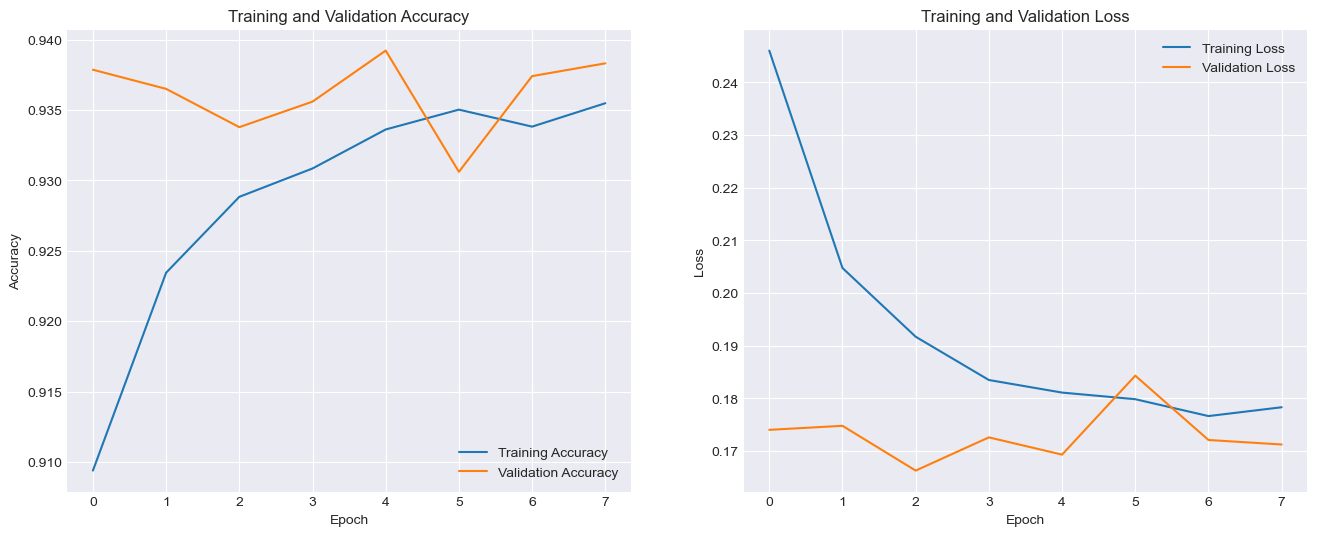

In [41]:
# Plot the training history
plot_training_history(mobilenet_history)

In [42]:
# Make predictions on the test set
y_pred_prob = mobilenet_model.predict(test_generator)
mobilenet_pred = (y_pred_prob > 0.5).astype(int) 

# 'test_generator.classes' gives the true labels of test data
mobilenet_true_labels = test_generator.classes

# Print classification report for precision, recall, F1-score
mobilenet_report = classification_report(mobilenet_true_labels, mobilenet_pred)
print(mobilenet_report)

87/87 [==============================] - 37s 415ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2756
           1       0.91      0.96      0.94      2756

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



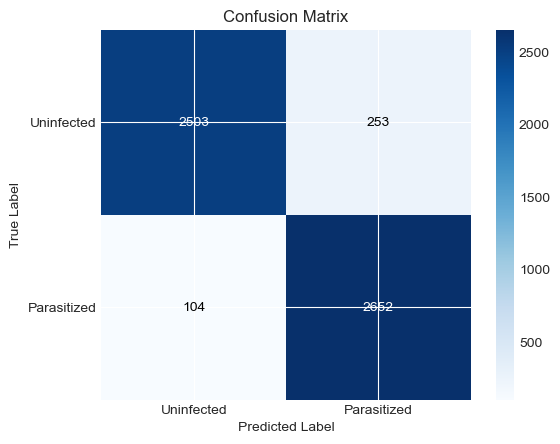

In [43]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, mobilenet_pred)

# Plot the confusion matrix with count
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# Annotate each cell with the count
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.yticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.show()

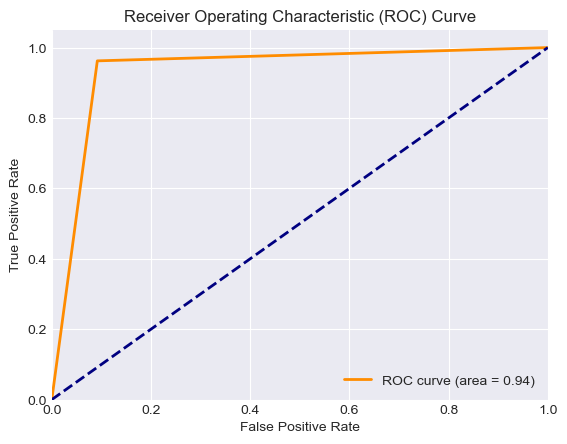

In [44]:
fpr, tpr, thresholds = roc_curve(mobilenet_true_labels, mobilenet_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# DenseNet121

In [45]:
# Define the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
dense_net_model = Sequential()

# Add the DenseNet121 base model to the new Sequential model
dense_net_model.add(base_model)

# Add a Flatten layer
dense_net_model.add(GlobalAveragePooling2D())

# Add a Dense layer with ReLU activation
dense_net_model.add(Dense(1024, activation='relu'))

# Add a Dropout layer for regularization
dense_net_model.add(Dropout(0.5))

# Add a Dense layer with sigmoid activation for binary classification
dense_net_model.add(Dense(1, activation='sigmoid'))

# Compile the model
dense_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
dense_net_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 8,088,129
Trainable params: 1,050,625
Non-trainable params: 7,037,504
____________________________________

In [46]:
# Specify the filepath with dynamic components
callbacks = [
    ModelCheckpoint(filepath='densenet_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    TensorBoard(log_dir='tensorboard_logs', histogram_freq=1, write_graph=True, write_images=True)
]

In [47]:
# Train the model
densenet_history1 = dense_net_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks)

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8882
Epoch 1: val_accuracy improved from -inf to 0.93832, saving model to densenet_model.h5
311/311 [==============================] - 658s 2s/step - loss: 0.3143 - accuracy: 0.8882 - val_loss: 0.1838 - val_accuracy: 0.9383
Epoch 2/20
311/311 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9181
Epoch 2: val_accuracy did not improve from 0.93832
311/311 [==============================] - 645s 2s/step - loss: 0.2161 - accuracy: 0.9181 - val_loss: 0.1703 - val_accuracy: 0.9374
Epoch 3/20
311/311 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9252
Epoch 3: val_accuracy did not improve from 0.93832
311/311 [==============================] - 648s 2s/step - loss: 0.2024 - accuracy: 0.9252 - val_loss: 0.1706 - val_accuracy: 0.9374
Epoch 4/20
311/311 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9247
Epoch 4: val_accuracy did not i

In [18]:
# Load the model
dense_net_model = load_model('densenet_model.h5')

In [44]:
# Evaluate the model on training data
train_loss, train_accuracy = dense_net_model.evaluate(train_generator, steps=len(train_generator))
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on validation data
val_loss, val_accuracy = dense_net_model.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on test data
test_loss, test_accuracy = dense_net_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

311/311 [==============================] - 595s 2s/step - loss: 0.1635 - accuracy: 0.9397
Training Loss: 0.1635, Training Accuracy: 93.97%
35/35 [==============================] - 64s 2s/step - loss: 0.1614 - accuracy: 0.9478
Validation Loss: 0.1614, Validation Accuracy: 94.78%
87/87 [==============================] - 159s 2s/step - loss: 0.1624 - accuracy: 0.9401
Test Loss: 0.1624, Test Accuracy: 94.01%


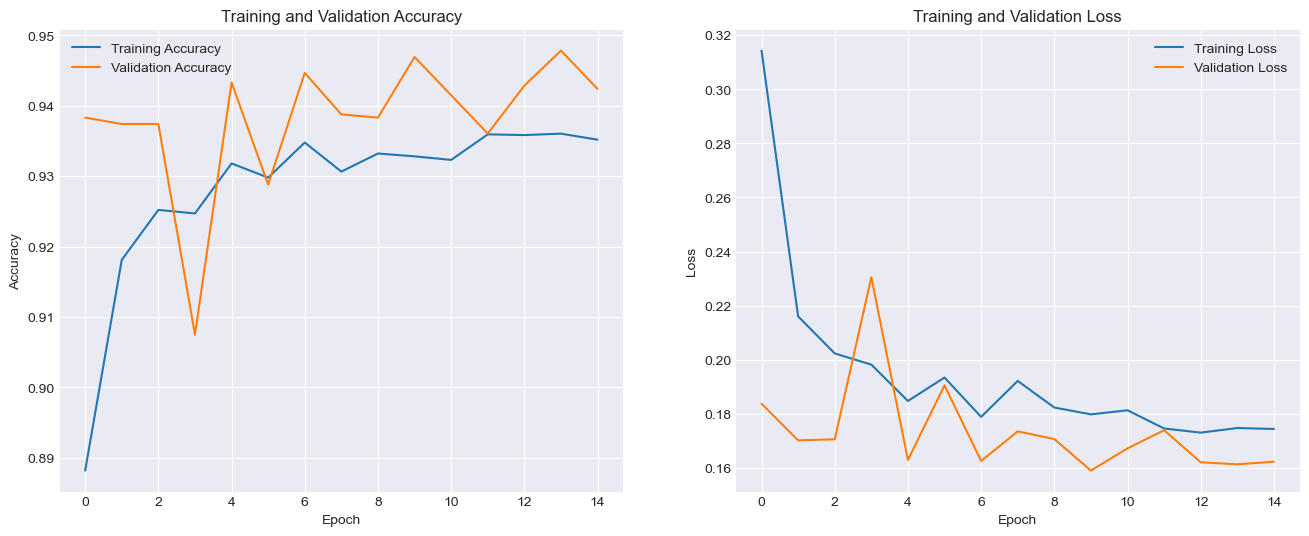

In [50]:
# Plot the training history
plot_training_history(densenet_history1)

In [45]:
# Make predictions on the test set
y_pred_prob = dense_net_model.predict(test_generator)
densenet_pred = (y_pred_prob > 0.5).astype(int)

# test_generator.classes gives the true labels of test data
densenet_true_labels = test_generator.classes

# Print classification report for precision, recall, F1-score
densenet_report = classification_report(densenet_true_labels, densenet_pred)
print(densenet_report)

87/87 [==============================] - 161s 2s/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2756
           1       0.95      0.93      0.94      2756

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



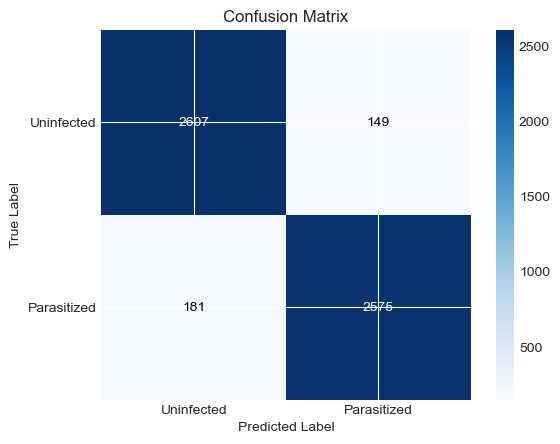

In [52]:
# Generate confusion matrix
conf_matrix = confusion_matrix(densenet_true_labels, densenet_pred)

# Plot the confusion matrix with count
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# Annotate each cell with the count
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.yticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.show()

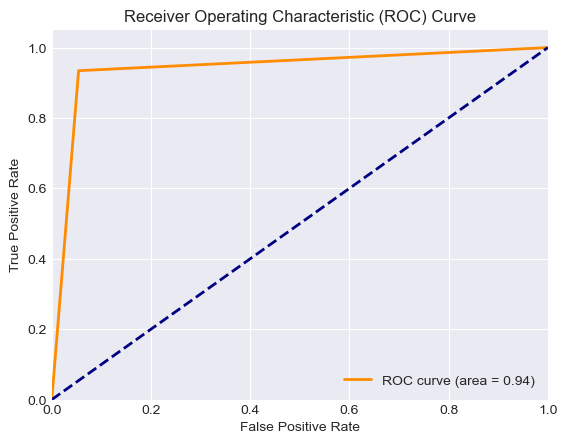

In [53]:
fpr, tpr, thresholds = roc_curve(densenet_true_labels, densenet_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Xception

In [14]:
# Define the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
xception_model = Sequential()

# Add the Xception base model to the new Sequential model
xception_model.add(base_model)

# Add a Flatten layer
xception_model.add(GlobalAveragePooling2D())

# Add a Dense layer with ReLU activation
xception_model.add(Dense(1024, activation='relu'))

# Add a Dropout layer for regularization
xception_model.add(Dropout(0.5))

# Add a Dense layer with sigmoid activation for binary classification
xception_model.add(Dense(1, activation='sigmoid'))

# Compile the model
xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
xception_model.summary()

# Specify the filepath with dynamic components
filepath = 'xception_model.h5'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22,960,681
Trainable params: 2,099,201
Non-trainable params: 20,861,480
____________________________________

In [15]:
callbacks = [
    ModelCheckpoint(filepath='xception_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    TensorBoard(log_dir='tensorboard_logs', histogram_freq=1, write_graph=True, write_images=True)
]

In [16]:
# Train the model
xception_history = xception_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks)

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8937
Epoch 1: val_accuracy improved from -inf to 0.92063, saving model to xception_model.h5
311/311 [==============================] - 1047s 3s/step - loss: 0.2698 - accuracy: 0.8937 - val_loss: 0.1933 - val_accuracy: 0.9206
Epoch 2/20
311/311 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9119
Epoch 2: val_accuracy did not improve from 0.92063
311/311 [==============================] - 831s 3s/step - loss: 0.2315 - accuracy: 0.9119 - val_loss: 0.2132 - val_accuracy: 0.9161
Epoch 3/20
311/311 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9161
Epoch 3: val_accuracy improved from 0.92063 to 0.93560, saving model to xception_model.h5
311/311 [==============================] - 822s 3s/step - loss: 0.2198 - accuracy: 0.9161 - val_loss: 0.1721 - val_accuracy: 0.9356
Epoch 4/20
311/311 [==============================] - ETA: 0s - loss: 0.2187 - accuracy

In [19]:
# Load the model
xception_model = load_model('xception_model.h5')

In [47]:
# Evaluate the model on training data
train_loss, train_accuracy = xception_model.evaluate(train_generator, steps=len(train_generator))
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on validation data
val_loss, val_accuracy = xception_model.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate the model on test data
test_loss, test_accuracy = xception_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

311/311 [==============================] - 651s 2s/step - loss: 0.1854 - accuracy: 0.9310
Training Loss: 0.1854, Training Accuracy: 93.10%
35/35 [==============================] - 75s 2s/step - loss: 0.1586 - accuracy: 0.9433
Validation Loss: 0.1586, Validation Accuracy: 94.33%
87/87 [==============================] - 227s 3s/step - loss: 0.1809 - accuracy: 0.9343
Test Loss: 0.1809, Test Accuracy: 93.43%


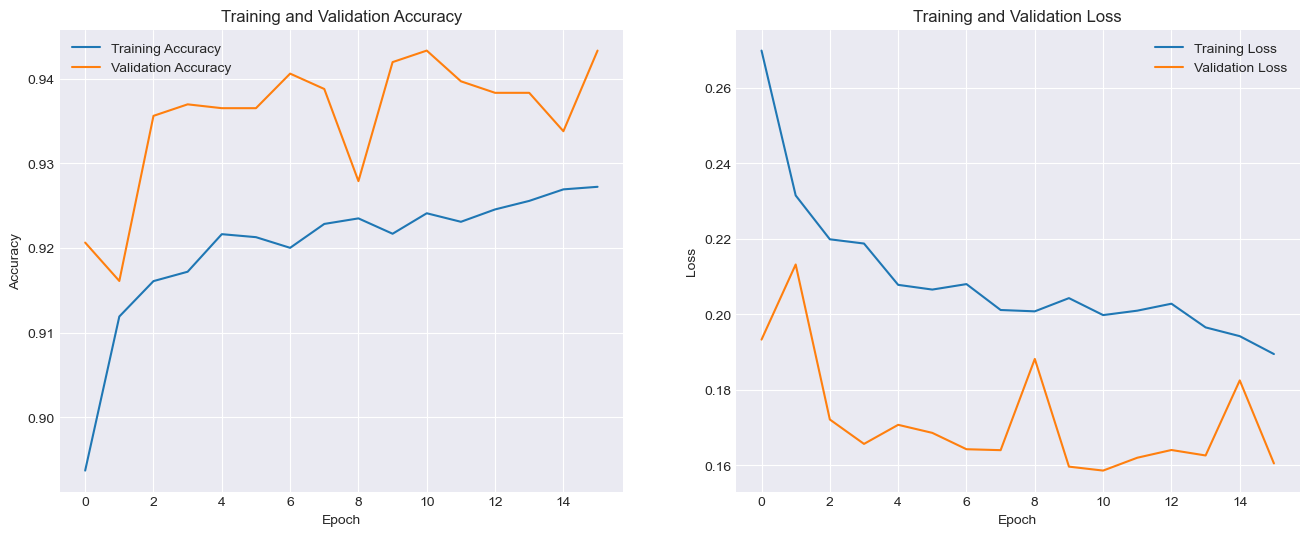

In [19]:
# Plot the training history
plot_training_history(xception_history)

In [48]:
# Make predictions on the test set
y_pred_prob = xception_model.predict(test_generator)
xception_pred = (y_pred_prob > 0.5).astype(int)

# test_generator.classes gives the true labels of test data
xception_true_labels = test_generator.classes

# Print classification report for precision, recall, F1-score
xception_report = classification_report(xception_true_labels, xception_pred)
print(xception_report)

87/87 [==============================] - 221s 3s/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2756
           1       0.93      0.94      0.93      2756

    accuracy                           0.93      5512
   macro avg       0.93      0.93      0.93      5512
weighted avg       0.93      0.93      0.93      5512



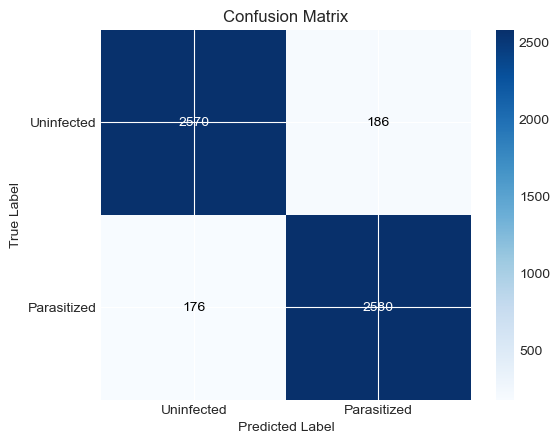

In [21]:
# Generate confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, xception_pred)

# Plot the confusion matrix with count
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# Annotate each cell with the count
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.yticks(ticks=[0, 1], labels=['Uninfected', 'Parasitized'])
plt.show()

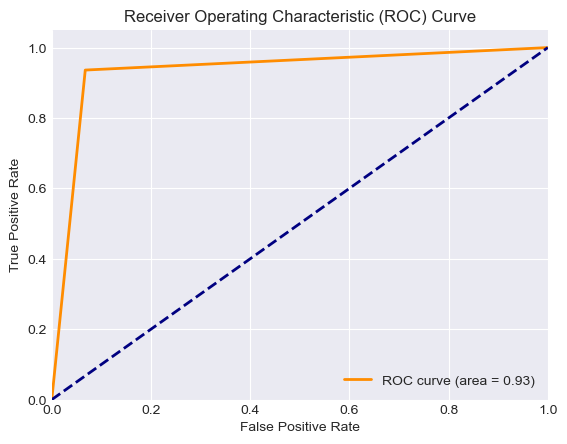

In [22]:
fpr, tpr, thresholds = roc_curve(xception_true_labels, xception_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

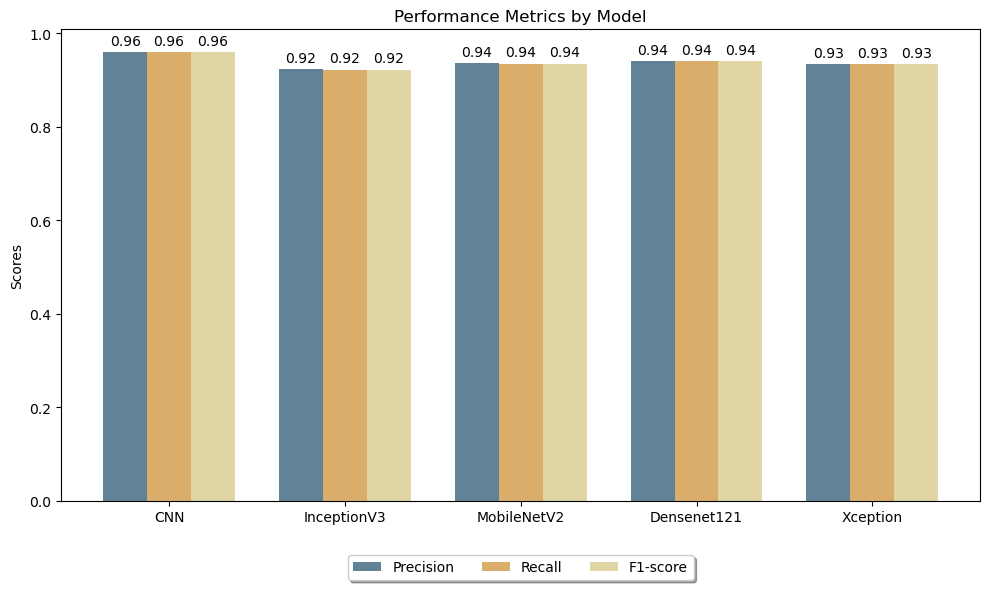

In [69]:
# Compute classification reports for each model
report_cnn = classification_report(true_labels, y_pred, output_dict=True)
inception_report = classification_report(inception_true_labels, inception_pred, output_dict=True)
mobilenet_report = classification_report(mobilenet_true_labels, mobilenet_pred, output_dict=True)
densenet_report = classification_report(densenet_true_labels, densenet_pred, output_dict=True)
xception_report = classification_report(xception_true_labels, xception_pred, output_dict=True)

# Extract precision, recall, and F1-score for each model
models_metrics = {
    'CNN': {
        'precision': report_cnn['macro avg']['precision'],
        'recall': report_cnn['macro avg']['recall'],
        'f1-score': report_cnn['macro avg']['f1-score']
    },
    'InceptionV3': {
        'precision': inception_report['macro avg']['precision'],
        'recall': inception_report['macro avg']['recall'],
        'f1-score': inception_report['macro avg']['f1-score']
    },
    'MobileNetV2': {
        'precision': mobilenet_report['macro avg']['precision'],
        'recall': mobilenet_report['macro avg']['recall'],
        'f1-score': mobilenet_report['macro avg']['f1-score']
    },
    'Densenet121': {
        'precision': densenet_report['macro avg']['precision'],
        'recall': densenet_report['macro avg']['recall'],
        'f1-score': densenet_report['macro avg']['f1-score']
    },
    'Xception': {
        'precision': xception_report['macro avg']['precision'],
        'recall': xception_report['macro avg']['recall'],
        'f1-score': xception_report['macro avg']['f1-score']
    }
}

# Extracting metrics
precision_values = [models_metrics[model]['precision'] for model in models_metrics]
recall_values = [models_metrics[model]['recall'] for model in models_metrics]
f1_score_values = [models_metrics[model]['f1-score'] for model in models_metrics]
models = list(models_metrics.keys())

# Define more matured colors
colors = ['#628395', '#dbad6a', '#dfd5a5']

# Plotting the bar plot
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, precision_values, width, label='Precision', color=colors[0])
rects2 = ax.bar(x, recall_values, width, label='Recall', color=colors[1])
rects3 = ax.bar(x + width, f1_score_values, width, label='F1-score', color=colors[2])

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=360)  

# Function to add labels just outside the box
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

# Positioning legend outside the box
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)

fig.tight_layout()

plt.show()

1/1 [==============================] - 0s 83ms/step


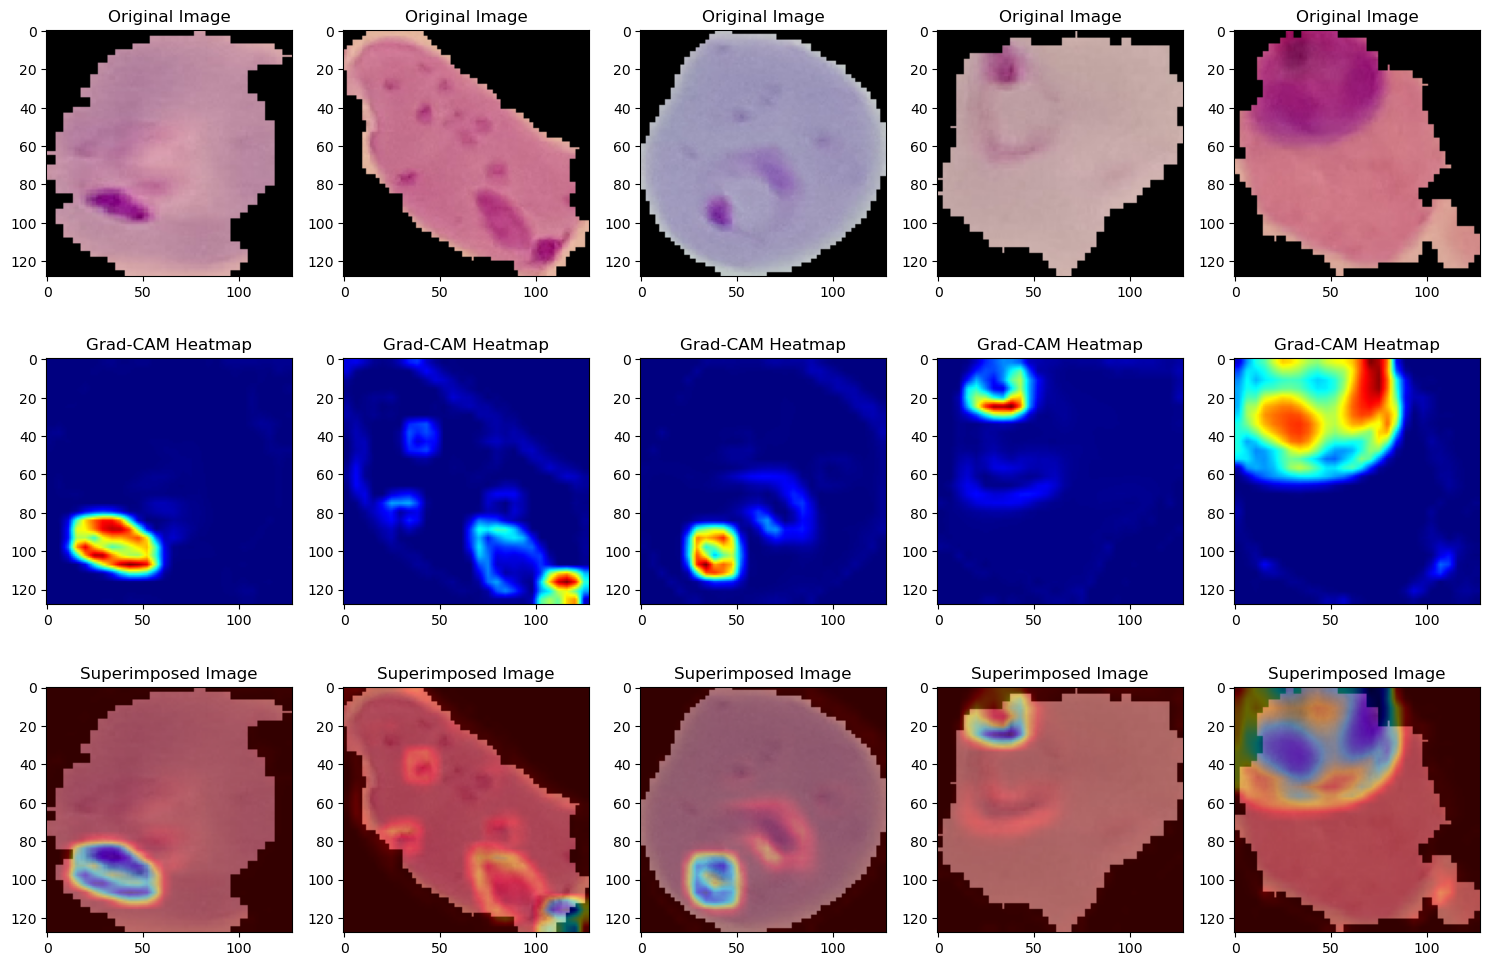

In [152]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the custom CNN model
custom_model = load_model('malaria_cnn_model.h5')


# Function to generate Grad-CAM heatmap
def generate_gradcam(image_path, axes):
    # Load the image and preprocess
    img = image.load_img(image_path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize pixel values

    # Get the top predicted class
    predictions = custom_model.predict(x)
    predicted_class = np.argmax(predictions[0])

    # Get the output tensor of the last convolutional layer
    last_conv_layer = custom_model.get_layer('conv2d_2')

    # Create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(inputs=[custom_model.inputs], outputs=[last_conv_layer.output, custom_model.output])

    # Compute the gradient of the top predicted class concerning the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the class activation map (CAM)
    cam = np.mean(conv_outputs[0], axis=-1)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (x.shape[2], x.shape[1]))  # Resize CAM to match original image size
    cam = cam / cam.max()

    # Generate heatmap overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(
        cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2BGR), 0.6,
        np.uint8(heatmap), 0.4, 0
    )

    # Plot the original image, Grad-CAM heatmap, and the superimposed image
    axes[0].imshow(np.uint8(img))
    axes[0].set_title('Original Image')

    axes[1].imshow(heatmap)
    axes[1].set_title('Grad-CAM Heatmap')

    axes[2].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Superimposed Image')


# Load the CSV file containing image data
image_data = pd.read_csv("image_data.csv")

# Filter 'Parasitized' images
parasitized_images = image_data[image_data['label'] == 'Parasitized']

# Randomly select 5 image paths
num_images = 5
random_image_paths = np.random.choice(parasitized_images['file_path'].values, num_images, replace=False)

# Generate Grad-CAM for each random image
fig, axes = plt.subplots(3, num_images, figsize=(15, 10))

for i, image_path in enumerate(random_image_paths):
    generate_gradcam(image_path, axes[:, i])

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 31ms/step


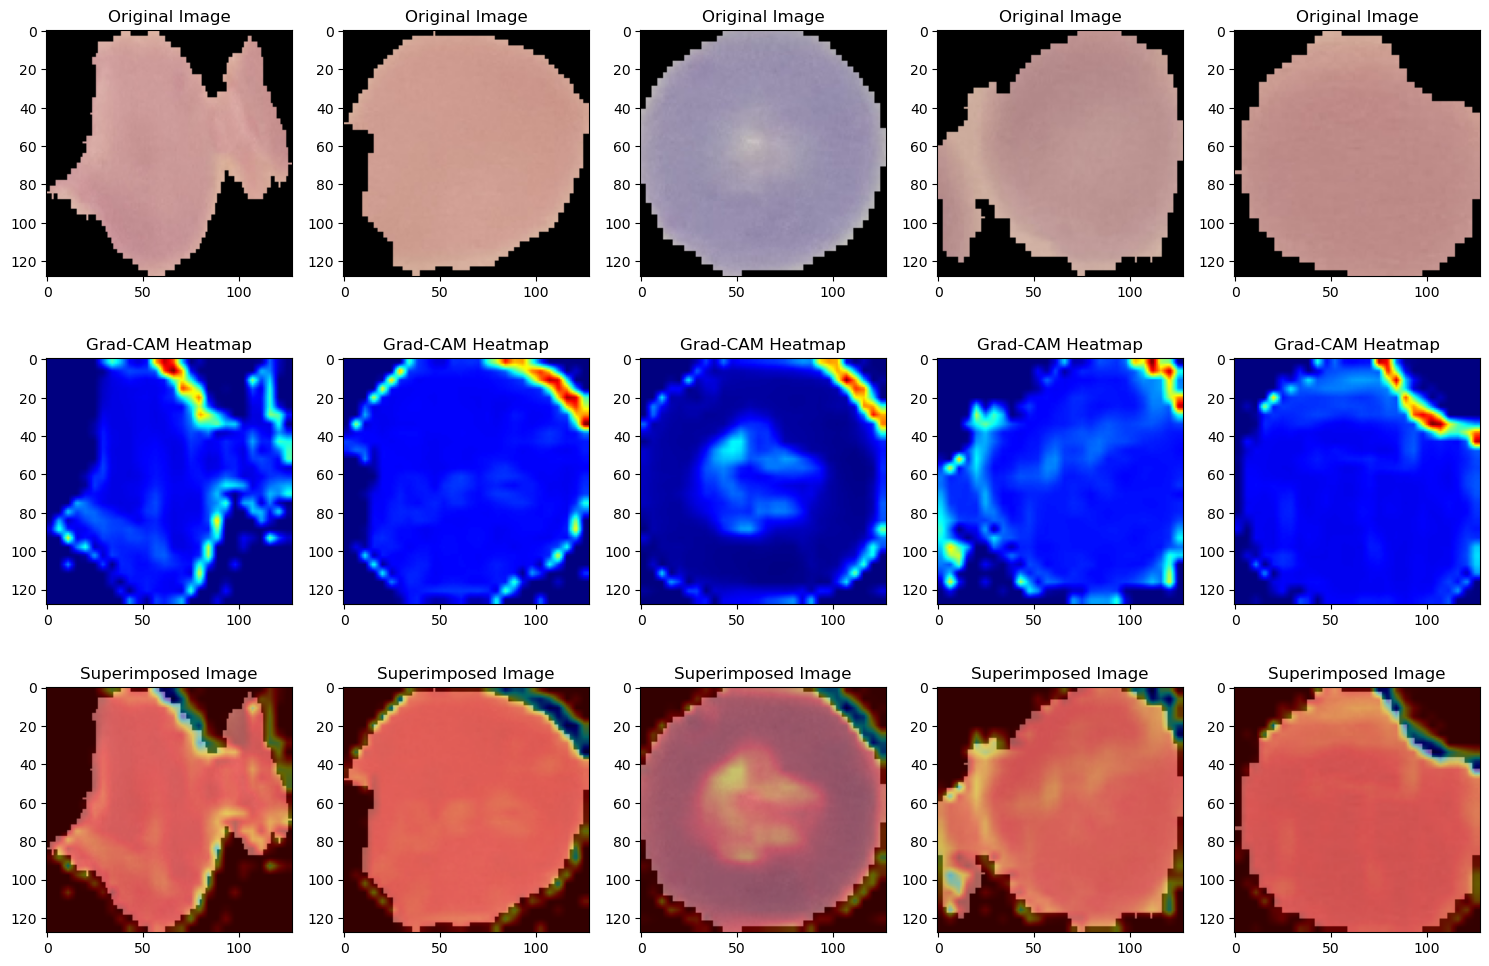

In [18]:
# Filter 'Uninfected' images
uninfected_images = image_data[image_data['label'] == 'Uninfected']

# Randomly select 5 image paths of uninfected cells
num_images = 5
random_uninfected_image_paths = np.random.choice(uninfected_images['file_path'].values, num_images, replace=False)

# Generate Grad-CAM for each random image
fig, axes = plt.subplots(3, num_images, figsize=(15, 10))

for i, image_path in enumerate(random_uninfected_image_paths):
    generate_gradcam(image_path, axes[:, i])

plt.tight_layout()
plt.show()